In [ ]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.8 MB/s eta 0:00:00


In [ ]:
!pip install python-louvain

Imports

In [ ]:
import pandas as pd
import zipfile
import io
import pickle
from scipy.stats import spearmanr
import pycountry
import requests
from matplotlib import cm
import community as community_louvain
from datetime import datetime, timedelta
from tqdm import tqdm
import plotly.express as px
import os
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import glob
import plotly.graph_objects as go
from google.colab import drive
import dask.dataframe as dd
import community as community_louvain
import community.community_louvain as community_louvain
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)  # Show all columns
# pd.reset_option('display.max_columns')

Mounted at /content/drive


###Global:

In [ ]:
# url = "https://www.gdeltproject.org/data/lookups/CSV.header.dailyupdates.txt"
# headers = requests.get(url).text.strip().split('\t')
# headers

In [ ]:
#fixing columns mismatch - there is one attribute missing 3 times (Actor1Geo_ADM2Code., Actor2Geo_ADM2Code.,ActionGeo_ADM2Code.)
headers = ['GLOBALEVENTID',
 'SQLDATE',
 'MonthYear',
 'Year',
 'FractionDate',
 'Actor1Code',
 'Actor1Name',
 'Actor1CountryCode',
 'Actor1KnownGroupCode',
 'Actor1EthnicCode',
 'Actor1Religion1Code',
 'Actor1Religion2Code',
 'Actor1Type1Code',
 'Actor1Type2Code',
 'Actor1Type3Code',
 'Actor2Code',
 'Actor2Name',
 'Actor2CountryCode',
 'Actor2KnownGroupCode',
 'Actor2EthnicCode',
 'Actor2Religion1Code',
 'Actor2Religion2Code',
 'Actor2Type1Code',
 'Actor2Type2Code',
 'Actor2Type3Code',
 'IsRootEvent',
 'EventCode',
 'EventBaseCode',
 'EventRootCode',
 'QuadClass',
 'GoldsteinScale',
 'NumMentions',
 'NumSources',
 'NumArticles',
 'AvgTone',
 'Actor1Geo_Type',
 'Actor1Geo_FullName',
 'Actor1Geo_CountryCode',
 'Actor1Geo_ADM1Code',
 'Actor1Geo_ADM2Code',
 'Actor1Geo_Lat',
 'Actor1Geo_Long',
 'Actor1Geo_FeatureID',
 'Actor2Geo_Type',
 'Actor2Geo_FullName',
 'Actor2Geo_CountryCode',
 'Actor2Geo_ADM1Code',
 'Actor2Geo_ADM2Code',
 'Actor2Geo_Lat',
 'Actor2Geo_Long',
 'Actor2Geo_FeatureID',
 'ActionGeo_Type',
 'ActionGeo_FullName',
 'ActionGeo_CountryCode',
 'ActionGeo_ADM1Code',
 'ActionGeo_ADM2Code',
 'ActionGeo_Lat',
 'ActionGeo_Long',
 'ActionGeo_FeatureID',
 'DATEADDED',
 'SOURCEURL']

In [ ]:
# Israeli name variants
ISRAEL_VARIANTS = set([
    'israel', 'the state of israel', 'state of israel',
    'israeli', 'israeli government', 'israeli military',
    'jerusalem', 'tel aviv', 'isr', 'idf'])

In [ ]:
signif_columns = [
 'SQLDATE',
 'Actor1Code',
 'Actor1Name',
 'Actor1CountryCode',
 'Actor2Code',
 'Actor2Name',
 'Actor2CountryCode',
 'IsRootEvent',
 'EventCode',
 'EventBaseCode',
 'EventRootCode',
 'QuadClass',
 'GoldsteinScale',
 'NumMentions',
 'NumSources',
 'NumArticles',
 'AvgTone',
 'ActionGeo_FullName',
 'ActionGeo_CountryCode',
 'DATEADDED',
 'SOURCEURL']

#Data analysis

## Anslysis

In [ ]:
joined_path = '/content/drive/MyDrive/Miki/israeli_interactions_post_7th_w_cameo.parquet'
df = dd.read_parquet(joined_path)

In [ ]:
df.head()

,SQLDATE,Actor1Code,Actor1Name,Actor1CountryCode,Actor2Code,Actor2Name,Actor2CountryCode,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,ActionGeo_FullName,ActionGeo_CountryCode,DATEADDED,SOURCEURL,Event Description
0,20231007,<NA>,<NA>,<NA>,ISRSET,ISRAEL,ISR,1,190,190,19,4,-10.0,12,6,12,-11.2273361227336,Israel,IS,20231007000000,https://www.iranherald.com/news/273991510/pale...,"Use conventional military force, not specified..."
1,20231007,ISR,ISRAEL,ISR,<NA>,<NA>,<NA>,0,129,129,12,3,-5.0,5,1,5,-0.81234768480909,"Kyiv, Kyyiv, Misto, Ukraine",UP,20231007000000,https://www.politico.com/newsletters/national-...,Veto
2,20231007,ISR,ISRAEL,ISR,BUS,PRODUCER,<NA>,0,129,129,12,3,-5.0,5,1,5,-0.81234768480909,"Kyiv, Kyyiv, Misto, Ukraine",UP,20231007000000,https://www.politico.com/newsletters/national-...,Veto
3,20231007,ISR,ISRAEL,ISR,ISRSET,ISRAEL,ISR,1,193,193,19,4,-10.0,4,1,4,-10.8786610878661,Israel,IS,20231007000000,https://www.bignewsnetwork.com/news/273991510/...,Fight with small arms and light weapons
4,20231007,ISRSET,ISRAEL,ISR,ISR,ISRAEL,ISR,1,182,182,18,4,-9.5,12,6,12,-11.2273361227336,Israel,IS,20231007000000,https://www.iranherald.com/news/273991510/pale...,"Physically assault, not specified below"


In [ ]:
df.shape[0].compute()

4815024

filtering out records of events before October 2023 which accidently got into the data (only 4126 such records)

In [ ]:
df = df[df['SQLDATE'] >= '2023-10-01']
df.shape[0].compute()

4810898

In [ ]:
# The total number of rows where either 'Actor1Code' or 'Actor2Code' is None
total_none_actors = df['Actor1Code'].isna().sum().compute() + df['Actor2Code'].isna().sum().compute()

print(f"Number of rows where Actor1Code is None: {df['Actor1Code'].isna().sum().compute()}")
print(f"Number of rows where Actor2Code is None: {df['Actor2Code'].isna().sum().compute()}")
print(f"Total number of rows where Actor1Code or Actor2Code is None: {total_none_actors}")

Number of rows where Actor1Code is None: 136247
Number of rows where Actor2Code is None: 409850
Total number of rows where Actor1Code or Actor2Code is None: 546097


Count in how many records throughout the dataset an action occurd in Israel but the actors weren't Israeli.
Its about 8% of the data.

In [ ]:
filtered_df = df[~df['Actor1Name'].str.lower().isin(ISRAEL_VARIANTS) &
            ~df['Actor2Name'].str.lower().isin(ISRAEL_VARIANTS) & ~df['Actor1CountryCode'].str.lower().isin(ISRAEL_VARIANTS) & ~df['Actor2CountryCode'].str.lower().isin(ISRAEL_VARIANTS) & (df['ActionGeo_CountryCode'].str.lower().isin(ISRAEL_VARIANTS) | df['ActionGeo_FullName'].str.lower().isin(ISRAEL_VARIANTS))]
filtered_df.shape[0].compute()

389374

Drawing monthly Goldstein and AVG_tone Scale by ActionGeo_CountryCode

In [ ]:
# Convert SQLDATE to datetime
df['SQLDATE'] = dd.to_datetime(df['SQLDATE'], format='%Y%m%d', errors='coerce')

# Filter out old or invalid dates
df = df[df['SQLDATE'] >= '2023-10-01']

#Drop NA's before aggregation (only 6 missing goldsteinscale values and only 2000 for the ActionGeo_CountryCode)
df = df.dropna(subset=['GoldsteinScale', 'ActionGeo_CountryCode'])

# Convert to month-year string
df['MonthYear'] = df['SQLDATE'].dt.to_period('M').astype(str)

# Convert ActionGeo_CountryCode from ISO-2 to ISO-3
def convert_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df['ActionGeo_CountryCode'] = df['ActionGeo_CountryCode'].map(convert_to_iso3, meta=('ActionGeo_CountryCode', 'object'))

# Drop rows where conversion failed
df = df.dropna(subset=['ActionGeo_CountryCode'])

# Convert GoldsteinScale and AvgTone to numeric safely
df['GoldsteinScale'] = df['GoldsteinScale'].map_partitions(pd.to_numeric, errors='coerce')
df['AvgTone'] = df['AvgTone'].map_partitions(pd.to_numeric, errors='coerce')

# Group by MonthYear and CountryCode
monthly_country_agg = df.groupby(['MonthYear', 'ActionGeo_CountryCode'])[['GoldsteinScale', 'AvgTone']].mean().compute()

# Reset index and rename column
monthly_country_agg = monthly_country_agg.reset_index()
monthly_country_agg.rename(columns={'ActionGeo_CountryCode': 'CountryCode'}, inplace=True)

min_val = monthly_country_agg['GoldsteinScale'].min()
max_val = monthly_country_agg['GoldsteinScale'].max()

# Create sorted list of months for animation steps
months = sorted(monthly_country_agg['MonthYear'].unique())



# Create choropleth map
fig = px.choropleth(monthly_country_agg,
                    locations="CountryCode",
                    color="GoldsteinScale",
                    hover_name="CountryCode",
                    animation_frame="MonthYear",
                    projection="natural earth",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=[min_val, max_val],
                    title="Monthly Average GoldsteinScale by Country")

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'),
    sliders=[dict(steps=[dict(args=[[m], dict(mode='immediate', frame=dict(duration=300, redraw=True), transition=dict(duration=0))], label=m) for m in months])])

fig.show()
fig.write_html("my_choropleth_map.html", auto_open=True)

In [ ]:
# Convert SQLDATE to datetime
df['SQLDATE'] = dd.to_datetime(df['SQLDATE'], format='%Y%m%d', errors='coerce')

# Filter out old or invalid dates (optional: adjust to your actual dataset start)
df = df[df['SQLDATE'] >= '2023-10-01']

#Drop NA's before aggregation (only 6 missing goldsteinscale values and only 2000 for the ActionGeo_CountryCode)
df = df.dropna(subset=['GoldsteinScale', 'ActionGeo_CountryCode'])

# Convert to month-year string
df['MonthYear'] = df['SQLDATE'].dt.to_period('M').astype(str)

# Convert ActionGeo_CountryCode from ISO-2 to ISO-3
def convert_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df['ActionGeo_CountryCode'] = df['ActionGeo_CountryCode'].map(convert_to_iso3, meta=('ActionGeo_CountryCode', 'object'))

# Drop rows where conversion failed
df = df.dropna(subset=['ActionGeo_CountryCode'])

# Convert GoldsteinScale and AvgTone to numeric
df['GoldsteinScale'] = df['GoldsteinScale'].map_partitions(pd.to_numeric, errors='coerce')
df['AvgTone'] = df['AvgTone'].map_partitions(pd.to_numeric, errors='coerce')

# Group by MonthYear and CountryCode
monthly_country_agg = df.groupby(['MonthYear', 'ActionGeo_CountryCode'])[['GoldsteinScale', 'AvgTone']].mean().compute()

# Reset index and rename column
monthly_country_agg = monthly_country_agg.reset_index()
monthly_country_agg.rename(columns={'ActionGeo_CountryCode': 'CountryCode'}, inplace=True)

# Create sorted list of months for animation steps
months = sorted(monthly_country_agg['MonthYear'].unique())

min_val = monthly_country_agg['AvgTone'].min()
max_val = monthly_country_agg['AvgTone'].max()

# Create choropleth map
fig = px.choropleth(monthly_country_agg,
                    locations="CountryCode",
                    color="AvgTone",
                    hover_name="CountryCode",
                    animation_frame="MonthYear",
                    projection="natural earth",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=[min_val, max_val],
                    title="Monthly Average AvgTone by Country")

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'),
    sliders=[dict(steps=[dict(args=[[m], dict(mode='immediate', frame=dict(duration=300, redraw=True), transition=dict(duration=0))], label=m) for m in months])])

fig.show()
fig.write_html("avg_tone.html", auto_open=True)

Data is from 7th of october 2023 to 12th of june 2025 mening almost 20 months so I will build a sequence of time-sliced graphs in a monthly manner.

In [ ]:
# Ensure the 'SQLDATE' column is in datetime format
df['SQLDATE'] = dd.to_datetime(df['SQLDATE'], format='%Y%m%d', errors='coerce')

In [ ]:
def get_month_ranges(start_year, start_month, end_year, end_month):
    """
    Generates a list of (start_date, end_date) tuples for each month
    from a given start month/year to an end month/year.

    Args:
        start_year (int): The start year.
        start_month (int): The start month (1-12).
        end_year (int): The end year.
        end_month (int): The end month (1-12).

    Returns:
        list: A list of tuples, where each tuple is (start_of_month, end_of_month).
    """
    date_ranges = []
    current_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)

    while current_date <= end_date:
        # Calculate the end of the current month
        next_month = current_date.replace(day=28) + timedelta(days=4)  # go to next month
        end_of_month = next_month - timedelta(days=next_month.day) # subtract days of next month to get last day of current month

        date_ranges.append((current_date, end_of_month))

        # Move to the next month
        current_date = next_month.replace(day=1)

    return date_ranges

# Define the start and end dates
start_year = 2023
start_month = 10
end_year = 2025
end_month = 6

dates = []
# Get the list of monthly date ranges
monthly_ranges = get_month_ranges(start_year, start_month, end_year, end_month)

# Print the generated ranges
for start, end in monthly_ranges:
    print(f"Start: {start.strftime('%Y-%m-%d')}, End: {end.strftime('%Y-%m-%d')}")
    dates.append([start, end])

Start: 2023-10-01, End: 2023-10-31
Start: 2023-11-01, End: 2023-11-30
Start: 2023-12-01, End: 2023-12-31
Start: 2024-01-01, End: 2024-01-31
Start: 2024-02-01, End: 2024-02-29
Start: 2024-03-01, End: 2024-03-31
Start: 2024-04-01, End: 2024-04-30
Start: 2024-05-01, End: 2024-05-31
Start: 2024-06-01, End: 2024-06-30
Start: 2024-07-01, End: 2024-07-31
Start: 2024-08-01, End: 2024-08-31
Start: 2024-09-01, End: 2024-09-30
Start: 2024-10-01, End: 2024-10-31
Start: 2024-11-01, End: 2024-11-30
Start: 2024-12-01, End: 2024-12-31
Start: 2025-01-01, End: 2025-01-31
Start: 2025-02-01, End: 2025-02-28
Start: 2025-03-01, End: 2025-03-31
Start: 2025-04-01, End: 2025-04-30
Start: 2025-05-01, End: 2025-05-31
Start: 2025-06-01, End: 2025-06-30


In [ ]:
# mergin last two months because data is untill 12th of June 2025
dates[-2][1] = dates[-1][1]
dates = dates[:-1]
dates

[[datetime.datetime(2023, 10, 1, 0, 0), datetime.datetime(2023, 10, 31, 0, 0)],
 [datetime.datetime(2023, 11, 1, 0, 0), datetime.datetime(2023, 11, 30, 0, 0)],
 [datetime.datetime(2023, 12, 1, 0, 0), datetime.datetime(2023, 12, 31, 0, 0)],
 [datetime.datetime(2024, 1, 1, 0, 0), datetime.datetime(2024, 1, 31, 0, 0)],
 [datetime.datetime(2024, 2, 1, 0, 0), datetime.datetime(2024, 2, 29, 0, 0)],
 [datetime.datetime(2024, 3, 1, 0, 0), datetime.datetime(2024, 3, 31, 0, 0)],
 [datetime.datetime(2024, 4, 1, 0, 0), datetime.datetime(2024, 4, 30, 0, 0)],
 [datetime.datetime(2024, 5, 1, 0, 0), datetime.datetime(2024, 5, 31, 0, 0)],
 [datetime.datetime(2024, 6, 1, 0, 0), datetime.datetime(2024, 6, 30, 0, 0)],
 [datetime.datetime(2024, 7, 1, 0, 0), datetime.datetime(2024, 7, 31, 0, 0)],
 [datetime.datetime(2024, 8, 1, 0, 0), datetime.datetime(2024, 8, 31, 0, 0)],
 [datetime.datetime(2024, 9, 1, 0, 0), datetime.datetime(2024, 9, 30, 0, 0)],
 [datetime.datetime(2024, 10, 1, 0, 0), datetime.datetime(

In [ ]:
records_per_month = []
# Filter records per month
filtered_dfs = []
for start, end in dates:
    filtered_df = df[(df['SQLDATE'] >= start) & (df['SQLDATE'] <= end)]
    filtered_dfs.append(filtered_df)
    recs = filtered_df.shape[0].compute()
    records_per_month.append(recs)
    print(f"Num of records for {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}: {recs}")

Num of records for 2023-10-01 to 2023-10-31: 572895
Num of records for 2023-11-01 to 2023-11-30: 427285
Num of records for 2023-12-01 to 2023-12-31: 275209
Num of records for 2024-01-01 to 2024-01-31: 254685
Num of records for 2024-02-01 to 2024-02-29: 233562
Num of records for 2024-03-01 to 2024-03-31: 216889
Num of records for 2024-04-01 to 2024-04-30: 301880
Num of records for 2024-05-01 to 2024-05-31: 277891
Num of records for 2024-06-01 to 2024-06-30: 184275
Num of records for 2024-07-01 to 2024-07-31: 171476
Num of records for 2024-08-01 to 2024-08-31: 195128
Num of records for 2024-09-01 to 2024-09-30: 216570
Num of records for 2024-10-01 to 2024-10-31: 293627
Num of records for 2024-11-01 to 2024-11-30: 176869
Num of records for 2024-12-01 to 2024-12-31: 149083
Num of records for 2025-01-01 to 2025-01-31: 174026
Num of records for 2025-02-01 to 2025-02-28: 163688
Num of records for 2025-03-01 to 2025-03-31: 144954
Num of records for 2025-04-01 to 2025-04-30: 137498
Num of recor

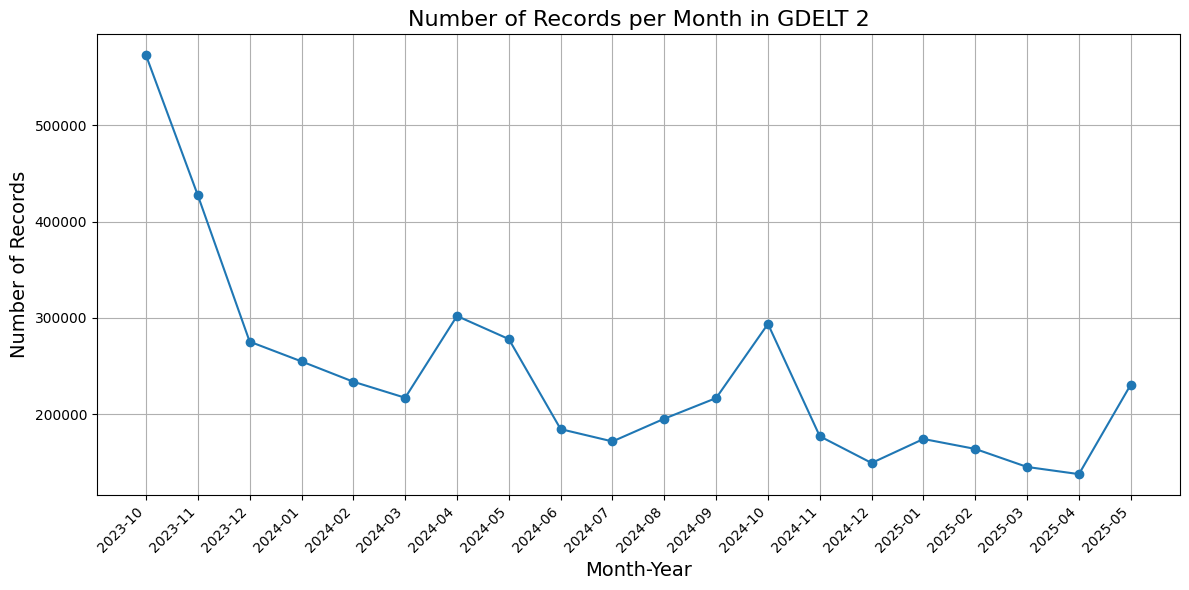

In [ ]:
# Create labels for the x-axis (Month-Year)
month_labels = [start.strftime('%Y-%m') for start, end in dates]

# Create the line plot
plt.figure(figsize=(12, 6))
plt.plot(month_labels, records_per_month, marker='o', linestyle='-')
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Records', fontsize=14)
plt.title('Number of Records per Month in GDELT 2', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


GoldsteinScale depends on the Cameo Event code hence objectively scores the severity/positivity of the event while the AvgTone subjectively measures positivity/severity through the tone of the documnets mentioned the event.
As seen there isn't a simple linear relationship between them, however in general as goldstein increases avgtone increases too.

In [ ]:
# Select the relevant columns
goldstein_tone_df = df[['GoldsteinScale', 'AvgTone']]

# Convert relevant columns to numeric, coercing errors
goldstein_tone_df['GoldsteinScale'] = goldstein_tone_df['GoldsteinScale'].map_partitions(lambda col: pd.to_numeric(col, errors='coerce').astype('float64'))
goldstein_tone_df['AvgTone'] = goldstein_tone_df['AvgTone'].map_partitions(lambda col: pd.to_numeric(col, errors='coerce').astype('float64'))

# Drop rows with NaN values in these columns
goldstein_tone_df = goldstein_tone_df.dropna()

goldstein_tone_pandas_df = goldstein_tone_df.compute()

# Calculate the Spearman correlation coefficient
correlation, p_value = spearmanr(goldstein_tone_pandas_df['GoldsteinScale'], goldstein_tone_pandas_df['AvgTone'])

print(f"Correlation between GoldsteinScale and AvgTone: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

Correlation between GoldsteinScale and AvgTone: 0.2724
P-value: 0.0000


### Graph analysis

In [ ]:
def construct_graph(df):
  # Converting numeric attributes from strings to numeric
  df['GoldsteinScale'] = df['GoldsteinScale'].map_partitions(lambda col: pd.to_numeric(col, errors='coerce').astype('float64'))

  df['AvgTone'] = df['AvgTone'].map_partitions(lambda col: pd.to_numeric(col, errors='coerce').astype('float64'))
  # Filter positive and negative events based on GoldsteinScale
  pos_df = df[df['GoldsteinScale'] > 0]
  neg_df = df[df['GoldsteinScale'] < 0]

  # Group and average GoldsteinScale and AvgTone for positive events
  pos_grouped = pos_df.groupby(
      ['Actor1CountryCode', 'Actor2CountryCode'])[['GoldsteinScale', 'AvgTone']].mean().reset_index()

  # Group and average for negative events
  neg_grouped = neg_df.groupby(
      ['Actor1CountryCode', 'Actor2CountryCode']
  )[['GoldsteinScale', 'AvgTone']].mean().reset_index()

  # Create a directed graph
  W = nx.DiGraph()

  # Add positive sentiment edges
  for _, row in pos_grouped.iterrows():
      W.add_edge(
          row['Actor1CountryCode'],
          row['Actor2CountryCode'],
          sentiment='positive',
          avg_goldstein=row['GoldsteinScale'],
          avg_tone=row['AvgTone']
      )

  # Add negative sentiment edges
  for _, row in neg_grouped.iterrows():
      W.add_edge(
          row['Actor1CountryCode'],
          row['Actor2CountryCode'],
          sentiment='negative',
          avg_goldstein=row['GoldsteinScale'],
          avg_tone=row['AvgTone'])
  return W

#### Whole DF graph:

In [ ]:
G = construct_graph(df)
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes (countries/entities): {num_nodes}")
print(f"Number of edges (interactions): {num_edges}")
print("\nSample Edge Attributes:")
for u, v, data in G.edges(data=True):
    print(f"({u}) -> ({v}): {data}")
    break

Number of nodes (countries/entities): 212
Number of edges (interactions): 4318

Sample Edge Attributes:
(ABW) -> (ISR): {'sentiment': 'positive', 'avg_goldstein': 2.45, 'avg_tone': -1.9622798508269674}


#### Gathering stats per graph

In [ ]:
def extract_monthly_stats(df,month_year):

    G = construct_graph(df)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Get total, in, and out degrees for actor ISR
    isr_total_degree = G.degree('ISR') if 'ISR' in G else 0
    isr_in_degree = G.in_degree('ISR') if 'ISR' in G else 0
    isr_out_degree = G.out_degree('ISR') if 'ISR' in G else 0

    # print(f"ISR Total Degree: {isr_total_degree}")
    # print(f"ISR In-Degree: {isr_in_degree}")
    # print(f"ISR Out-Degree: {isr_out_degree}")

    # Calculate positive and negative degrees for ISR
    isr_positive_in_degree = sum(1 for u, v, data in G.in_edges('ISR', data=True) if data.get('sentiment') == 'positive')
    isr_negative_in_degree = sum(1 for u, v, data in G.in_edges('ISR', data=True) if data.get('sentiment') == 'negative')
    isr_positive_out_degree = sum(1 for u, v, data in G.out_edges('ISR', data=True) if data.get('sentiment') == 'positive')
    isr_negative_out_degree = sum(1 for u, v, data in G.out_edges('ISR', data=True) if data.get('sentiment') == 'negative')
    isr_positive_total_degree = isr_positive_in_degree + isr_positive_out_degree
    isr_negative_total_degree = isr_negative_in_degree + isr_negative_out_degree

    # print(f"\nISR Positive Total Degree: {isr_positive_total_degree}")
    # print(f"ISR Positive In-Degree: {isr_positive_in_degree}")
    # print(f"ISR Positive Out-Degree: {isr_positive_out_degree}")
    # print(f"ISR Negative Total Degree: {isr_negative_total_degree}")
    # print(f"ISR Negative In-Degree: {isr_negative_in_degree}")
    # print(f"ISR Negative Out-Degree: {isr_negative_out_degree}")

    stats_dict = {
        'Month-Year': month_year,
        'NumNodes': num_nodes,
        'NumEdges': num_edges,
        'ISRTotalDegree': isr_total_degree,
        'ISRInDegree': isr_in_degree,
        'ISROutDegree': isr_out_degree,
        'ISRPositiveTotalDegree': isr_positive_total_degree,
        'ISRPositiveInDegree': isr_positive_in_degree,
        'ISRPositiveOutDegree': isr_positive_out_degree,
        'ISRNegativeTotalDegree': isr_negative_total_degree,
        'ISRNegativeInDegree': isr_negative_in_degree,
        'ISRNegativeOutDegree': isr_negative_out_degree
    }

    return  stats_dict

dict_list = []
for i, df in enumerate(filtered_dfs):
  stats_dict = extract_monthly_stats(df, dates[i][0].strftime('%Y-%m'))
  dict_list.append(stats_dict)
df_stats = pd.DataFrame(dict_list)
df_stats.to_csv('/content/drive/MyDrive/Miki/GDELT2_Data_post_7th.monthly_stats.csv', index = False)
df_stats

,Month-Year,NumNodes,NumEdges,ISRTotalDegree,ISRInDegree,ISROutDegree,ISRPositiveTotalDegree,ISRPositiveInDegree,ISRPositiveOutDegree,ISRNegativeTotalDegree,ISRNegativeInDegree,ISRNegativeOutDegree
0,2023-10,186,1559,339,176,163,51,21,30,288,155,133
1,2023-11,191,1379,340,179,161,52,23,29,288,156,132
2,2023-12,177,1146,305,158,147,53,21,32,252,137,115
3,2024-01,168,1191,303,158,145,65,31,34,238,127,111
4,2024-02,170,1066,287,148,139,45,24,21,242,124,118
5,2024-03,171,922,302,160,142,74,37,37,228,123,105
6,2024-04,168,1181,292,149,143,48,19,29,244,130,114
7,2024-05,178,1226,305,153,152,55,21,34,250,132,118
8,2024-06,165,1051,291,147,144,60,28,32,231,119,112
9,2024-07,156,938,269,140,129,49,21,28,220,119,101


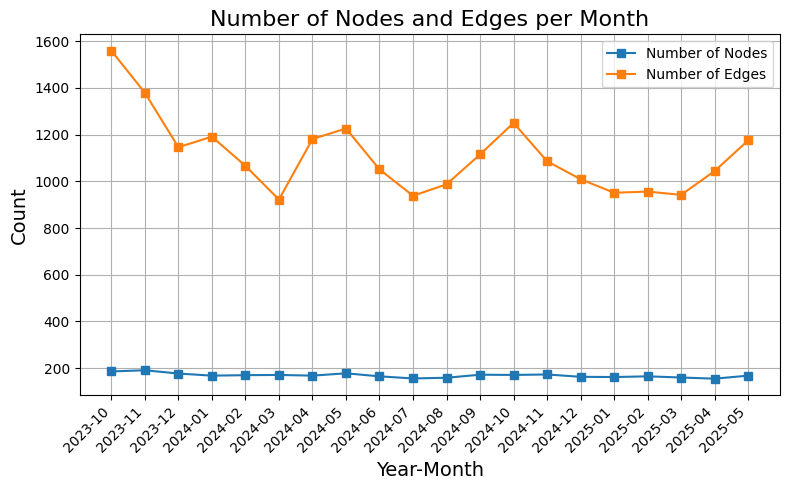

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_stats['Month-Year'], df_stats['NumNodes'], marker='s', label='Number of Nodes')
plt.plot(df_stats['Month-Year'], df_stats['NumEdges'], marker='s', label='Number of Edges')

plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Number of Nodes and Edges per Month', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Nodes remain the same while edges correlate with the records in the db

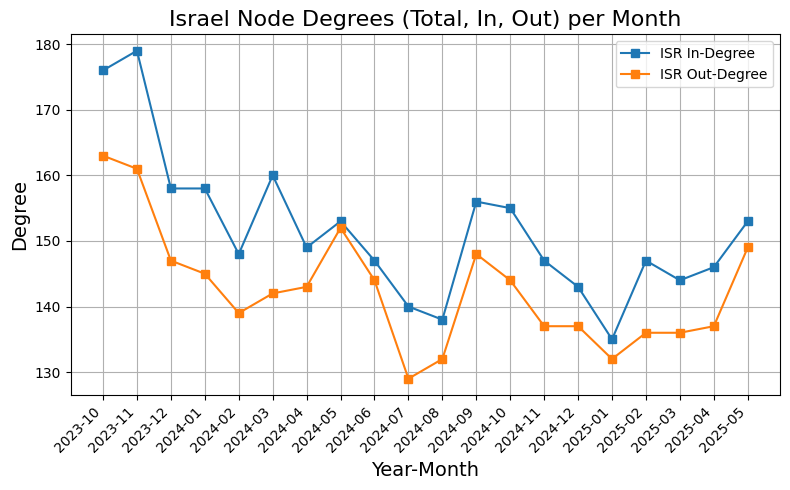

In [ ]:
plt.figure(figsize=(8, 5))
# plt.plot(df_stats['Month-Year'], df_stats['ISRTotalDegree'], marker='o', linestyle='-', label='ISR Total Degree')
plt.plot(df_stats['Month-Year'], df_stats['ISRInDegree'], marker='s', label='ISR In-Degree')
plt.plot(df_stats['Month-Year'], df_stats['ISROutDegree'], marker='s', label='ISR Out-Degree')

plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Degree', fontsize=14)
plt.title('Israel Node Degrees (Total, In, Out) per Month', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

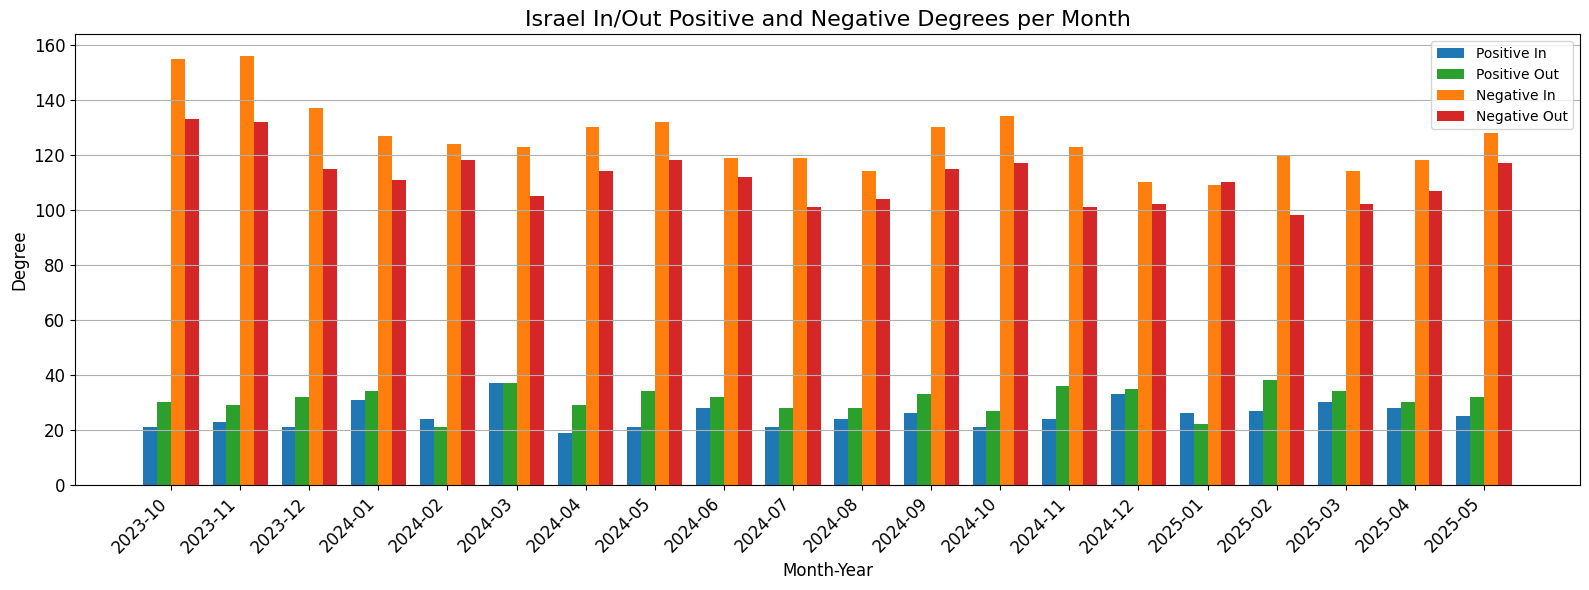

In [ ]:
# Define colors
colors = {
    'ISRPositiveInDegree': '#1f77b4',   # blue
    'ISRPositiveOutDegree': '#2ca02c',  # green
    'ISRNegativeInDegree': '#ff7f0e',   # orange
    'ISRNegativeOutDegree': '#d62728'   # red
}

# Create x locations
x = np.arange(len(df_stats['Month-Year']))
width = 0.2  # width of each bar

# Create the plot
plt.figure(figsize=(16, 6))

plt.bar(x - 1.5*width, df_stats['ISRPositiveInDegree'], width, label='Positive In', color=colors['ISRPositiveInDegree'])
plt.bar(x - 0.5*width, df_stats['ISRPositiveOutDegree'], width, label='Positive Out', color=colors['ISRPositiveOutDegree'])
plt.bar(x + 0.5*width, df_stats['ISRNegativeInDegree'], width, label='Negative In', color=colors['ISRNegativeInDegree'])
plt.bar(x + 1.5*width, df_stats['ISRNegativeOutDegree'], width, label='Negative Out', color=colors['ISRNegativeOutDegree'])

plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Degree', fontsize=12)
plt.title('Israel In/Out Positive and Negative Degrees per Month', fontsize=16)
plt.xticks(x, df_stats['Month-Year'], rotation=45, ha='right',fontsize = 12)
plt.legend(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()


#### Per month:

In [ ]:
# Helper to get top-k degree nodes
def get_top_k(degree_dict, k):
    sorted_degrees = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_degrees[:k]

# Collect data for facet plotting (only in and out degree)
def collect_plot_data(graph, label_prefix, k):
    data = []
    in_deg = dict(graph.in_degree())
    out_deg = dict(graph.out_degree())

    for node, deg in get_top_k(in_deg, k):
        data.append({'Node': node, 'Degree': deg, 'Type': 'In-Degree', 'Graph': label_prefix})
    for node, deg in get_top_k(out_deg, k):
        data.append({'Node': node, 'Degree': deg, 'Type': 'Out-Degree', 'Graph': label_prefix})

    return data

def plot_top_player_degrees(G, k):
    # Build positive and negative subgraphs
    G_pos = G.edge_subgraph([
        (u, v) for u, v, d in G.edges(data=True)
        if d.get('sentiment') == 'positive']).copy()

    G_neg = G.edge_subgraph([
        (u, v) for u, v, d in G.edges(data=True)
        if d.get('sentiment') == 'negative']).copy()

    # Collect plot data for positive and negative
    plot_data = (
        collect_plot_data(G_pos, 'Positive', k) +
        collect_plot_data(G_neg, 'Negative', k)
    )
    df_plot = pd.DataFrame(plot_data)

    # Determine order of nodes based on average degree across all data
    order = (
        df_plot.groupby("Node")["Degree"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
    )

    # Create FacetGrid with sharex=False to show x-tick labels on all facets
    g = sns.FacetGrid(df_plot, row="Graph", col="Type", margin_titles=True, height=4, sharex=False)
    g.map_dataframe(sns.barplot, x="Node", y="Degree", palette="viridis", order=order)

    g.set_titles(row_template="{row_name}", col_template="{col_name}", size=14)
    g.set_axis_labels("Node", "Degree", fontsize=14)

    # Set x-ticks and labels on all axes
    for ax in g.axes.flat:
        ax.set_xticks(range(len(order)))   # tick positions
        ax.set_xticklabels(order, rotation=90, ha='center')  # tick labels and rotation

    plt.tight_layout()
    plt.show()

Taking only top K nodes with most extreme interactions (pos or neg)

In [ ]:
print(f"Number of nodes in H: {H.number_of_nodes()}")
print(f"Number of edges in H: {H.number_of_edges()}")

Number of nodes in H: 55
Number of edges in H: 60


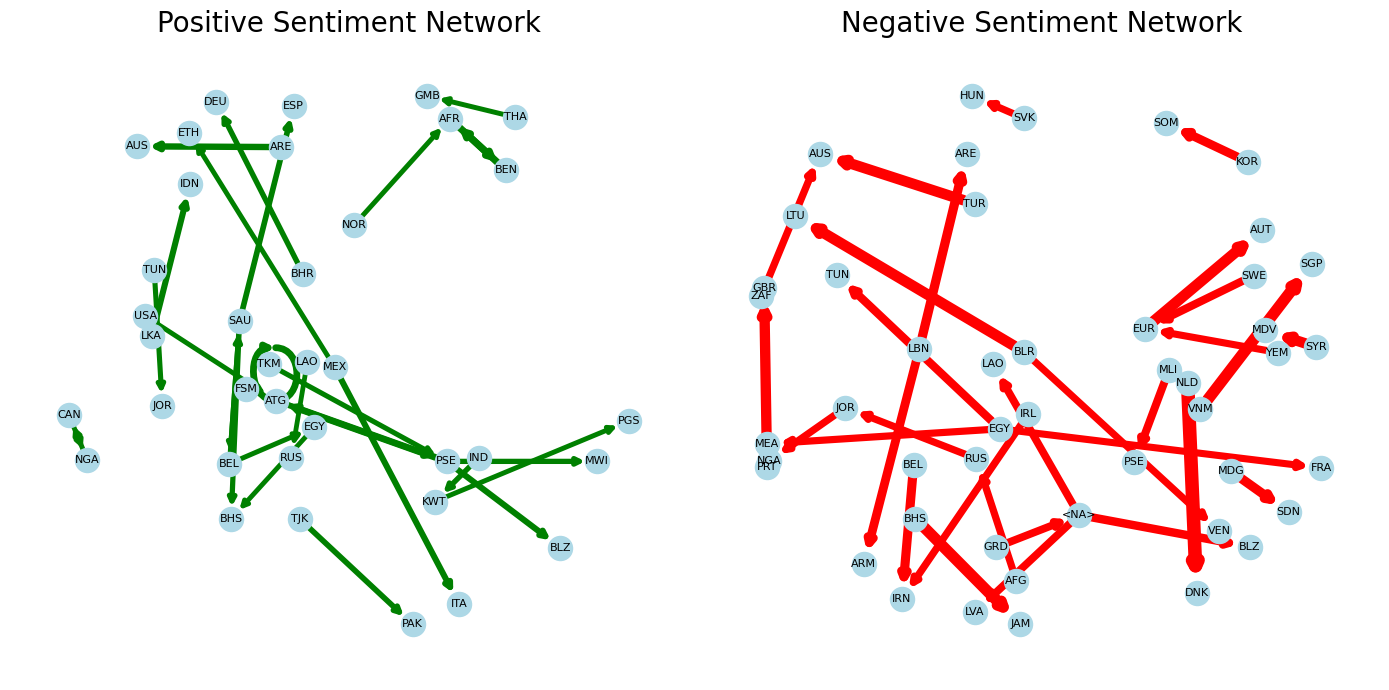

In [ ]:
def plot_top_k_pos_and_neg_graph(G,N):
  # Sort and take top N positive and negative edges

  pos_edges = sorted(
      [(u, v, d) for u, v, d in G.edges(data=True) if d['sentiment'] == 'positive'],
      key=lambda x: x[2]['avg_tone'],
      reverse=True)[:N]

  neg_edges = sorted(
      [(u, v, d) for u, v, d in G.edges(data=True) if d['sentiment'] == 'negative'],
      key=lambda x: x[2]['avg_tone'])[:N]

  # Build a subgraph from these edges
  H = nx.DiGraph()
  for u, v, d in pos_edges + neg_edges:
      H.add_edge(u, v, **d)

  # Compute layout
  pos = nx.spring_layout(H, k=0.5, seed=42)

  # Filter edges
  pos_edges = [(u, v) for u, v, d in H.edges(data=True) if d['sentiment'] == 'positive']
  neg_edges = [(u, v) for u, v, d in H.edges(data=True) if d['sentiment'] == 'negative']

  # Get nodes with at least one edge
  connected_nodes_pos = set([u for u, v in pos_edges] + [v for u, v in pos_edges])
  connected_nodes_neg = set([u for u, v in neg_edges] + [v for u, v in neg_edges])

  # Edge widths
  edge_weights_pos = [H[u][v]['avg_tone']*0.5 for u, v in pos_edges]
  edge_weights_neg = [abs(H[u][v]['avg_tone'])*0.5 for u, v in neg_edges]

  # Create subplots
  fig, axes = plt.subplots(1, 2, figsize=(14, 7))

  # Positive sentiment plot
  nx.draw_networkx_nodes(H, pos, nodelist=connected_nodes_pos, node_size=300, node_color='lightblue', ax=axes[0])
  nx.draw_networkx_labels(H, pos, labels={n: n for n in connected_nodes_pos}, font_size=8, ax=axes[0])
  nx.draw_networkx_edges(H, pos, edgelist=pos_edges, edge_color='green', width=edge_weights_pos, arrows=True, ax=axes[0])
  axes[0].set_title("Positive Sentiment Network",fontsize=20)
  axes[0].axis('off')

  # Negative sentiment plot
  nx.draw_networkx_nodes(H, pos, nodelist=connected_nodes_neg, node_size=300, node_color='lightblue', ax=axes[1])
  nx.draw_networkx_labels(H, pos, labels={n: n for n in connected_nodes_neg}, font_size=8, ax=axes[1])
  nx.draw_networkx_edges(H, pos, edgelist=neg_edges, edge_color='red', width=edge_weights_neg, arrows=True, ax=axes[1])
  axes[1].set_title("Negative Sentiment Network", fontsize=20)
  axes[1].axis('off')

  # Show plot
  plt.tight_layout()
  plt.show()

plot_top_k_pos_and_neg_graph(G,30)

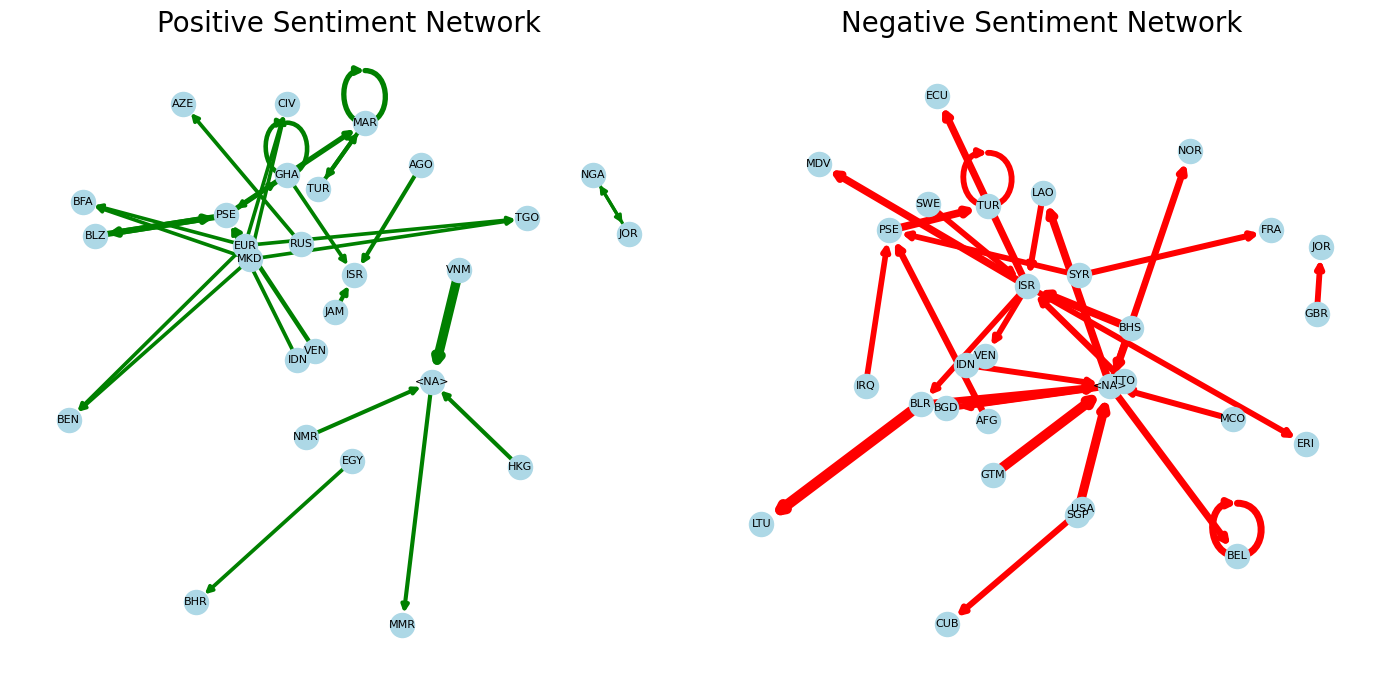

In [ ]:
plot_top_k_pos_and_neg_graph(network_list[15][0],30)

In [ ]:
G_jun_2024 = network_list[8][0]

pos_edges_count = sum(1 for u, v, data in G_jun_2024.edges(data=True) if data.get('sentiment') == 'positive')
neg_edges_count = sum(1 for u, v, data in G_jun_2024.edges(data=True) if data.get('sentiment') == 'negative')

print(f"Number of positive edges in June 2024: {pos_edges_count}")
print(f"Number of negative edges in June 2024: {neg_edges_count}")

Number of positive edges in June 2024: 449
Number of negative edges in June 2024: 597


In [ ]:
def plot_interactive(G,N):
    # Sort and take top N positive and negative edges

  pos_edges = sorted(
      [(u, v, d) for u, v, d in G.edges(data=True) if d['sentiment'] == 'positive'],
      key=lambda x: x[2]['avg_tone'],
      reverse=True
  )[:N]

  neg_edges = sorted(
      [(u, v, d) for u, v, d in G.edges(data=True) if d['sentiment'] == 'negative'],
      key=lambda x: x[2]['avg_tone']
  )[:N]

  # Build a subgraph from these edges
  H = nx.DiGraph()
  for u, v, d in pos_edges + neg_edges:
      H.add_edge(u, v, **d)

  # pos = nx.kamada_kawai_layout(H)
  pos = nx.spring_layout(H, k=0.5, seed=42)

  # Edge traces
  edge_traces = []
  for u, v, data in H.edges(data=True):
      x0, y0 = pos[u]
      x1, y1 = pos[v]
      color = 'green' if data['sentiment'] == 'positive' else 'red'
      width = max(1, abs(data['avg_tone']))  # scale width
      edge_traces.append(
          go.Scatter(
              x=[x0, x1], y=[y0, y1],
              line=dict(width=width, color=color),
              hoverinfo='text',
              text=f"{u} → {v}<br>Sentiment: {data['sentiment']}<br>Goldstein: {data['avg_goldstein']:.2f}<br>AvgTone: {data['avg_tone']:.2f}",
              mode='lines')
      )

  # Node trace
  node_x = []
  node_y = []
  node_text = []

  for node in H.nodes():
      x, y = pos[node]
      node_x.append(x)
      node_y.append(y)
      node_text.append(node)

  node_trace = go.Scatter(
      x=node_x, y=node_y,
      mode='markers+text',
      text=node_text,
      textposition="top center",
      hoverinfo='text',
      marker=dict(size=10, color='lightblue', line=dict(width=1, color='black')))

  # Combine everything into a figure
  fig = go.Figure(
      data=edge_traces + [node_trace],
      layout=go.Layout(
          title="Interactive Sentiment Network",
          titlefont_size=20,
          showlegend=False,
          hovermode='closest',
          margin=dict(b=20,l=5,r=5,t=40),
          xaxis=dict(showgrid=False, zeroline=False),
          yaxis=dict(showgrid=False, zeroline=False)))

  fig.show()
plot_interactive(G,30)

In [ ]:
def detect_communities(G,N,visualize = True):
    # Sort and take top N positive and negative edges
  N = 30
  pos_edges = sorted(
      [(u, v, d) for u, v, d in G.edges(data=True) if d['sentiment'] == 'positive'],
      key=lambda x: x[2]['avg_tone'],
      reverse=True)[:N]

  neg_edges = sorted(
      [(u, v, d) for u, v, d in G.edges(data=True) if d['sentiment'] == 'negative'],
      key=lambda x: x[2]['avg_tone'])[:N]

  # Build a subgraph from these edges
  H = nx.DiGraph()
  for u, v, d in pos_edges + neg_edges:
      H.add_edge(u, v, **d)

  # Subgraphs by sentiment
  G_pos = G.edge_subgraph([
      (u, v) for u, v, d in G.edges(data=True)
      if d.get('sentiment') == 'positive']).copy()

  G_neg = G.edge_subgraph([
      (u, v) for u, v, d in G.edges(data=True)
      if d.get('sentiment') == 'negative']).copy()


  # Filter by H nodes
  top_nodes = set(H.nodes())
  G_pos_sub = G_pos.subgraph(top_nodes).copy()
  G_neg_sub = G_neg.subgraph(top_nodes).copy()

  # Ensure node names are not pandas.NA
  na_nodes_pos = [n for n in G_pos_sub.nodes if pd.isna(n)]
  na_nodes_neg = [n for n in G_neg_sub.nodes if pd.isna(n)]

  G_pos_sub.remove_nodes_from(na_nodes_pos)
  G_neg_sub.remove_nodes_from(na_nodes_neg)

  # Normalize edge weights to be non-negative
  def normalize_edge_weights(G_sub, weight_attr='avg_tone', new_attr='normalized_weight'):
      weights = [d[weight_attr] for _, _, d in G_sub.edges(data=True)]
      min_weight = min(weights)
      for u, v, d in G_sub.edges(data=True):
          d[new_attr] = d[weight_attr] - min_weight  # shift to make all weights ≥ 0

  normalize_edge_weights(G_pos_sub)
  normalize_edge_weights(G_neg_sub)

  #  Louvain partition
  partition_pos = community_louvain.best_partition(G_pos_sub.to_undirected(), weight='normalized_weight')
  partition_neg = community_louvain.best_partition(G_neg_sub.to_undirected(), weight='normalized_weight')

  #  Layouts
  pos_layout = nx.kamada_kawai_layout(G_pos_sub)
  neg_layout = nx.kamada_kawai_layout(G_neg_sub)

  # Colors
  def get_colors(partition):
      num_comms = len(set(partition.values()))
      cmap = cm.get_cmap('tab10')
      return {node: cmap(comm_id % 10) for node, comm_id in partition.items()}
  if visualize:
    colors_pos = get_colors(partition_pos)
    colors_neg = get_colors(partition_neg)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Positive graph
    ax = axes[0]
    nx.draw_networkx_edges(G_pos_sub, pos_layout, ax=ax, alpha=0.4)
    nx.draw_networkx_nodes(G_pos_sub, pos_layout, ax=ax,
                           node_color=[colors_pos[n] for n in G_pos_sub.nodes()],
                           node_size=400)
    nx.draw_networkx_labels(G_pos_sub, pos_layout, ax=ax, font_size=8)
    ax.set_title("Positive Sentiment Communities (Top Nodes Only)")
    ax.axis('off')

    # Negative graph
    ax = axes[1]
    nx.draw_networkx_edges(G_neg_sub, neg_layout, ax=ax, alpha=0.4)
    nx.draw_networkx_nodes(G_neg_sub, neg_layout, ax=ax,
                           node_color=[colors_neg[n] for n in G_neg_sub.nodes()],
                           node_size=400)
    nx.draw_networkx_labels(G_neg_sub, neg_layout, ax=ax, font_size=8)
    ax.set_title("Negative Sentiment Communities (Top Nodes Only)")
    ax.axis('off')

    plt.show()
  return partition_pos, partition_neg

In [ ]:
oct_23 = network_list[0][0]

print(f"Number of nodes in G: {oct_23.number_of_nodes()}")
print(f"Number of edges in G: {oct_23.number_of_edges()}")

Number of nodes in G: 185
Number of edges in G: 1555


/tmp/ipython-input-3332286363.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


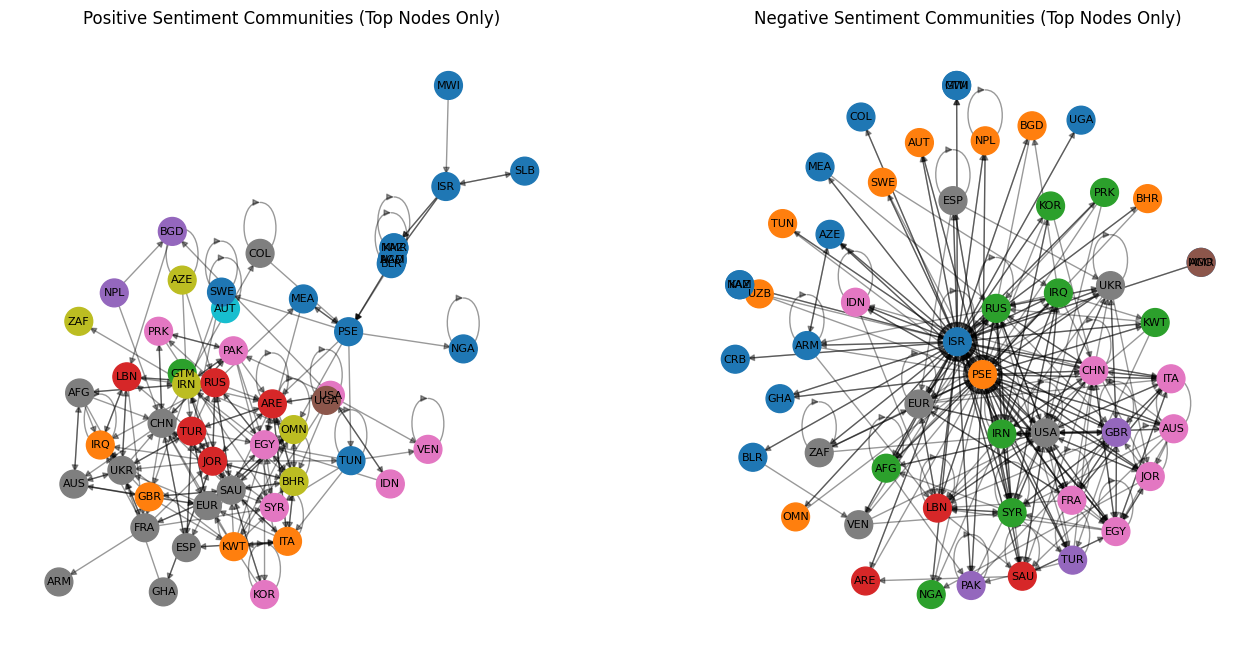

In [ ]:
partition_pos, partition_neg = detect_communities(oct_23,30,True)

In [ ]:
# Group nodes by community
communities = defaultdict(list)
for node, comm_id in partition_pos.items():
    communities[comm_id].append(node)

# Display communities
for comm_id, members in communities.items():
    print(f"Community {comm_id}: {members}")


Community 0: ['AGO', 'SLB', 'MWI', 'PSE', 'MEA', 'ISR', 'SWE', 'TUN', 'BLR', 'KAZ', 'NAM', 'NGA', 'MMR']
Community 1: ['KWT', 'ITA', 'IRQ', 'GBR']
Community 6: ['KOR', 'PRK', 'USA', 'IDN', 'EGY', 'SYR', 'PAK', 'VEN']
Community 4: ['BGD', 'NPL']
Community 7: ['COL', 'AUS', 'ESP', 'ARM', 'UKR', 'GHA', 'EUR', 'AFG', 'CHN', 'SAU', 'FRA']
Community 8: ['ZAF', 'AZE', 'IRN', 'OMN', 'BHR']
Community 9: ['AUT']
Community 2: ['GTM']
Community 3: ['LBN', 'RUS', 'JOR', 'ARE', 'TUR']
Community 5: ['UGA']


In [ ]:
# Group nodes by community
communities = defaultdict(list)
for node, comm_id in partition_neg.items():
    communities[comm_id].append(node)

# Display communities
for comm_id, members in communities.items():
    print(f"Community {comm_id}: {members}")

Community 0: ['AGO', 'MWI', 'COL', 'AZE', 'MEA', 'ISR', 'ARM', 'GTM', 'GHA', 'BLR', 'KAZ', 'CRB', 'NAM', 'UGA']
Community 2: ['KWT', 'KOR', 'PRK', 'IRQ', 'IRN', 'AFG', 'SYR', 'RUS', 'NGA']
Community 1: ['BGD', 'NPL', 'PSE', 'AUT', 'SWE', 'TUN', 'UZB', 'OMN', 'BHR']
Community 6: ['ITA', 'AUS', 'IDN', 'EGY', 'CHN', 'FRA', 'JOR']
Community 7: ['USA', 'ZAF', 'ESP', 'UKR', 'EUR', 'VEN']
Community 3: ['LBN', 'SAU', 'ARE']
Community 4: ['PAK', 'TUR', 'GBR']
Community 5: ['MMR']


/tmp/ipython-input-26-1892125806.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')


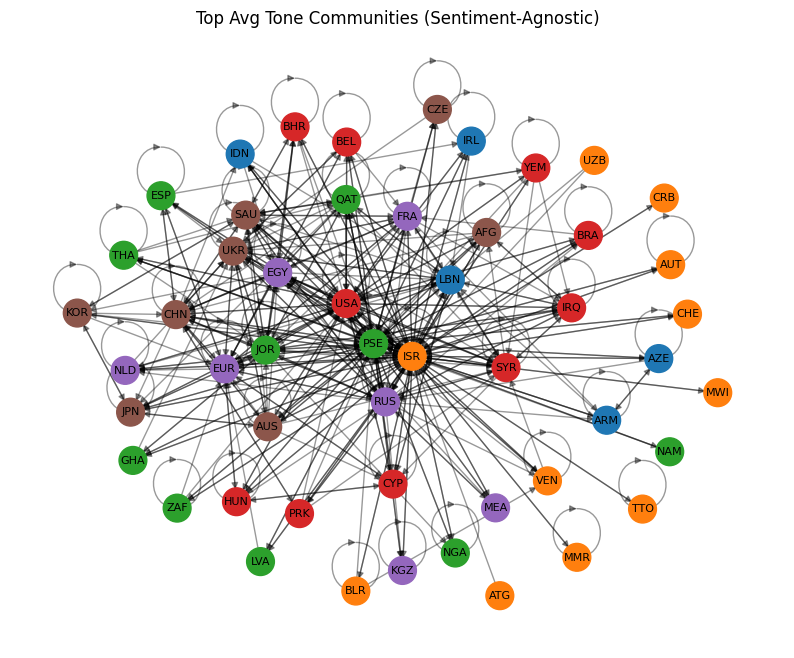

In [ ]:
N = 60  # Combined top N edges

# Sort edges by absolute avg_tone
top_edges = sorted(
    G.edges(data=True),
    key=lambda x: abs(x[2].get('avg_tone', 0)),
    reverse=True
)[:N]

# Build subgraph
H = nx.DiGraph()
for u, v, d in top_edges:
    H.add_edge(u, v, **d)

# Filter original graph by H's nodes
top_nodes = set(H.nodes())
G_sub = G.subgraph(top_nodes).copy()

# Remove NA nodes if any
na_nodes = [n for n in G_sub.nodes if pd.isna(n)]
G_sub.remove_nodes_from(na_nodes)

# Normalize edge weights to be non-negative
def normalize_edge_weights(G_sub, weight_attr='avg_tone', new_attr='normalized_weight'):
    weights = [abs(d.get(weight_attr, 0)) for _, _, d in G_sub.edges(data=True)]
    min_weight = min(weights)
    for u, v, d in G_sub.edges(data=True):
        d[new_attr] = abs(d.get(weight_attr, 0)) - min_weight  # shift to ≥ 0

normalize_edge_weights(G_sub)

# Louvain Community Detection
partition = community_louvain.best_partition(G_sub.to_undirected(), weight='normalized_weight')

# Layout and Colors
layout = nx.kamada_kawai_layout(G_sub)

def get_colors(partition):
    num_comms = len(set(partition.values()))
    cmap = cm.get_cmap('tab10')
    return {node: cmap(comm_id % 10) for node, comm_id in partition.items()}

colors = get_colors(partition)

# Plot
plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G_sub, layout, alpha=0.4)
nx.draw_networkx_nodes(G_sub, layout,
                       node_color=[colors[n] for n in G_sub.nodes()],
                       node_size=400)
nx.draw_networkx_labels(G_sub, layout, font_size=8)
plt.title("Top Avg Tone Communities (Sentiment-Agnostic)")
plt.axis('off')
plt.show()


In [ ]:
# Group nodes by community
communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

# Display communities
for comm_id, members in communities.items():
    print(f"Community {comm_id}: {members}")

NameError: name 'partition' is not defined

Visualizing Partitions through Time

In [ ]:
def align_partitions(prev_partition, current_partition):
  #The align_partitions function aims to make community labels consistent across different months.
    if not prev_partition:
        return current_partition
    mapping = {}
    prev_comms = {}
    for node, comm in prev_partition.items():
        prev_comms.setdefault(comm, set()).add(node)
    curr_comms = {}
    for node, comm in current_partition.items():
        curr_comms.setdefault(comm, set()).add(node)
    for curr_comm, curr_nodes in curr_comms.items():
        best_match = None
        best_score = -1
        for prev_comm, prev_nodes in prev_comms.items():
            score = len(curr_nodes & prev_nodes) / len(curr_nodes | prev_nodes)
            if score > best_score:
                best_score = score
                best_match = prev_comm
        mapping[curr_comm] = best_match if best_match is not None else curr_comm
    aligned_partition = {node: mapping[comm] for node, comm in current_partition.items()}
    return aligned_partition

Constract graphs and coupling with the month_year data

In [ ]:
network_list = []
for i, df in enumerate(tqdm(filtered_dfs, desc="Processing dataframes")):
    # Ensure 'GoldsteinScale' and 'AvgTone' are numeric before constructing the graph
    df['GoldsteinScale'] = df['GoldsteinScale'].map_partitions(lambda col: pd.to_numeric(col, errors='coerce').astype('float64'))
    df['AvgTone'] = df['AvgTone'].map_partitions(lambda col: pd.to_numeric(col, errors='coerce').astype('float64'))

    G = construct_graph(df)
    month_year = dates[i][0].strftime('%Y-%m')
    network_list.append((G, month_year))


Processing dataframes: 100%|██████████| 20/20 [12:50<00:00, 38.54s/it]


In [ ]:
pickle_output_path = '/content/drive/MyDrive/Miki/network_list.pkl'

# Save the network_list to a pickle file
with open(pickle_output_path, 'wb') as f:
    pickle.dump(network_list, f)

print(f"network_list successfully saved to {pickle_output_path}")

network_list successfully saved to /content/drive/MyDrive/Miki/network_list.pkl


In [ ]:
pickle_input_path = '/content/drive/MyDrive/Miki/network_list.pkl'

# Load the list of networks from the pickle file
with open(pickle_input_path, 'rb') as f:
    network_list = pickle.load(f)


In [ ]:
dict_list = []
for G, month_str in tqdm(network_list, desc="Iterating over networks and dfs"):
  partition_neg, partition_pos = detect_communities(G, 30, False)
  for country,comm in partition_neg.items():
    neg_community_dict = {}
    neg_community_dict["CountryCode"] = country
    neg_community_dict["Community"] = comm
    neg_community_dict["Month"] = month_str
    neg_community_dict["Sentiment"] = "Negative"
    dict_list.append(neg_community_dict)

  for country,comm in partition_pos.items():
    pos_community_dict = {}
    pos_community_dict["CountryCode"] = country
    pos_community_dict["Community"] = comm
    pos_community_dict["Month"] = month_str
    pos_community_dict["Sentiment"] = "Positive"
    dict_list.append(pos_community_dict)
community_df = pd.DataFrame(dict_list)
community_df

Iterating over networks and dfs: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]


,CountryCode,Community,Month,Sentiment
0,PSE,3,2023-10,Negative
1,SAU,2,2023-10,Negative
2,BGD,6,2023-10,Negative
3,NAM,3,2023-10,Negative
4,MWI,3,2023-10,Negative
...,...,...,...,...
1997,CHN,1,2025-05,Positive
1998,GBR,2,2025-05,Positive
1999,JOR,0,2025-05,Positive
2000,MKD,7,2025-05,Positive


In [ ]:
from collections import defaultdict
import pandas as pd

def remap_communities_over_time(df):
    snapshots = sorted(df['Month'].unique())
    consistent_ids = {}
    next_id = 0
    previous_communities = {}

    df['community_id'] = -1

    for t in snapshots:
        current = df[df['Month'] == t]
        current_groups = current.groupby('Community')

        matched = {}
        for community_label, group in current_groups:
            countries = set(group['CountryCode'])

            # Try to match with previous
            best_match = None
            best_score = 0
            for prev_label, prev_countries in previous_communities.items():
                score = len(countries & prev_countries) / len(countries | prev_countries)
                if score > best_score and score > 0.3:  # threshold
                    best_score = score
                    best_match = prev_label

            if best_match is not None:
                matched[community_label] = consistent_ids[best_match]
            else:
                matched[community_label] = next_id
                next_id += 1

            df.loc[(df['Month'] == t) & (df['Community'] == community_label), 'community_id'] = matched[community_label]

        # Update for next round
        previous_communities = {
            c: set(df[(df['Month'] == t) & (df['Community'] == c)]['CountryCode'])
            for c in current_groups.groups
        }
        consistent_ids = {**consistent_ids, **{c: matched[c] for c in matched}}

    return df

In [ ]:
pos_community_df = community_df[community_df["Sentiment"]=="Positive"]
neg_community_df  = community_df[community_df["Sentiment"]=="Negative"]
print(f"Number of records in positive df is: {pos_community_df.shape[0]}")
print(f"Number of records in negative df is: {neg_community_df.shape[0]}")

Number of records in positive df is: 1000
Number of records in negative df is: 1002


In [ ]:
def visualize_communities_over_time(df, sentiment):
  df = remap_communities_over_time(df)
  # Define a palette
  unique_ids = sorted(df['community_id'].unique())
  palette = px.colors.qualitative.Alphabet[:len(unique_ids)]
  color_map = dict(zip(unique_ids, palette))
  df['color'] = df['community_id'].map(color_map)


  counts = df.groupby(['Month', 'community_id'])['CountryCode'].count().reset_index(name='count')
  df = df.merge(counts, on=['Month', 'community_id'])
  df = df[df['count'] > 1]

  fig = px.choropleth(
      df,
      locations="CountryCode",
      color=df['community_id'].astype(str),
      animation_frame="Month",
      hover_name="CountryCode",
      # hover_data={'hover': True},   # Show custom text
      scope="world",
      color_discrete_sequence=px.colors.qualitative.Alphabet)
  fig.update_layout(title=f"Top {sentiment} Political Community Evolution Over Time",
      title_font_size=20,
      title_x=0.5  ,legend_title_text="Community")
  fig.show()
  fig.write_html("my_plot.html", auto_open=True)

In [ ]:
visualize_communities_over_time(neg_community_df,"Negative")

/tmp/ipython-input-39-386325251.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-72-3657765685.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
visualize_communities_over_time(pos_community_df,"Positive")

/tmp/ipython-input-39-386325251.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-67-1727078648.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




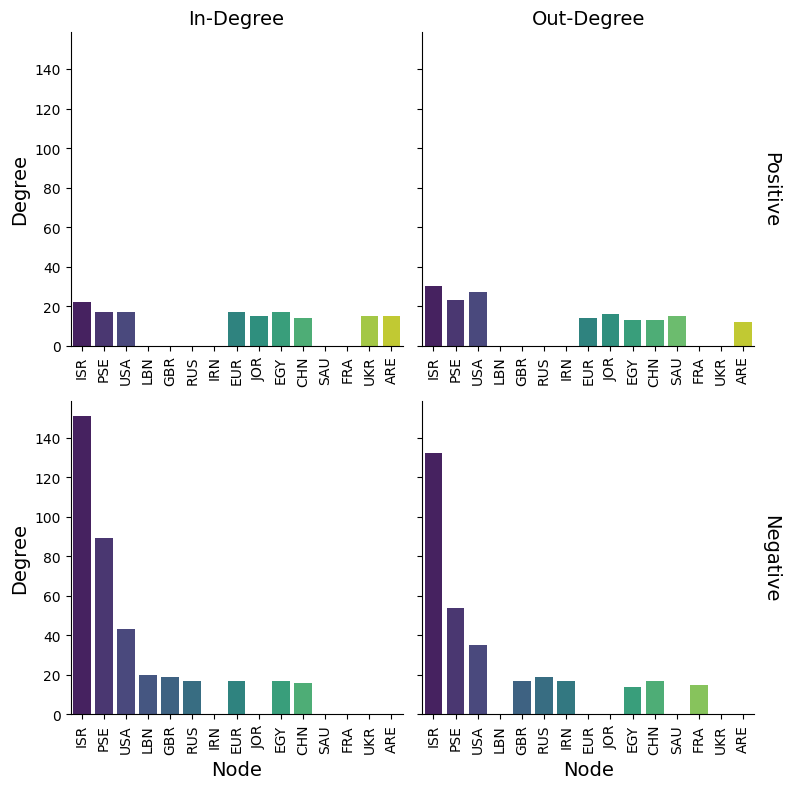

In [ ]:
G = network_list[0][0]
plot_top_player_degrees(G, 10)